In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime


In [2]:
# Load merged stock sentiment data for TSLA, AAPL, and AMZN
stock_files = {'TSLA': 'TSLA_merged_data.csv', 'AAPL': 'AAPL_merged_data.csv', 'AMZN': 'AMZN_merged_data.csv'}
stock_data = {stock: pd.read_csv(file) for stock, file in stock_files.items()}

# Ensure the 'Close' column exists and is properly parsed
for stock, df in stock_data.items():
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure date parsing
    print(f"Loaded {stock} data with {len(df)} rows.")


Loaded TSLA data with 252 rows.
Loaded AAPL data with 252 rows.
Loaded AMZN data with 252 rows.


C:\Users\tings\AppData\Local\Temp\ipykernel_28000\2910079502.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])  # Ensure date parsing
C:\Users\tings\AppData\Local\Temp\ipykernel_28000\2910079502.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])  # Ensure date parsing
C:\Users\tings\AppData\Local\Temp\ipykernel_28000\2910079502.py:7: FutureWarning: In a future ve

In [4]:
stock_data['TSLA']

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock,RSI,...,UpperBand,MiddleBand,LowerBand,Tweet,Stock Name,Company Name,cleaned_text,Sentiment,Sentiment_Score,Volume_Weighted_Sentiment
0,2021-09-01 00:00:00-04:00,244.693329,247.330002,243.756668,244.696671,39612900,0.0,0.0,TSLA,0.000000,...,0.000000,0.000000,0.000000,0,0,0,0,0.0,0,0
1,2021-09-02 00:00:00-04:00,244.833328,246.990005,243.513336,244.130005,38331900,0.0,0.0,TSLA,0.000000,...,0.000000,0.000000,0.000000,0,0,0,0,0.0,0,0
2,2021-09-03 00:00:00-04:00,244.083328,244.666672,241.399994,244.523331,45738300,0.0,0.0,TSLA,0.000000,...,0.000000,0.000000,0.000000,0,0,0,0,0.0,0,0
3,2021-09-07 00:00:00-04:00,246.666672,253.399994,246.419998,250.973328,60119400,0.0,0.0,TSLA,0.000000,...,0.000000,0.000000,0.000000,0,0,0,0,0.0,0,0
4,2021-09-08 00:00:00-04:00,253.860001,254.816666,246.923340,251.289993,56379000,0.0,0.0,TSLA,0.000000,...,0.000000,0.000000,0.000000,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2022-08-25 00:00:00-04:00,302.359985,302.959991,291.600006,296.070007,53230000,0.0,3.0,TSLA,55.864367,...,312.192481,297.646835,283.101189,0,0,0,0,0.0,0,0
248,2022-08-26 00:00:00-04:00,297.429993,302.000000,287.470001,288.089996,57163900,0.0,0.0,TSLA,50.647895,...,312.325664,297.193835,282.062006,0,0,0,0,0.0,0,0
249,2022-08-29 00:00:00-04:00,282.829987,287.739990,280.700012,284.820007,41864700,0.0,0.0,TSLA,48.643451,...,312.634673,296.571002,280.507332,0,0,0,0,0.0,0,0
250,2022-08-30 00:00:00-04:00,287.869995,288.480011,272.649994,277.700012,50541800,0.0,0.0,TSLA,44.512652,...,313.337595,295.426669,277.515744,0,0,0,0,0.0,0,0


In [5]:
# Hyperparameters
sequence_length = 30
batch_size = 8
epochs = 100
learning_rate = 0.001
hidden_dim = 128
num_layers = 2

# Define LSTM Model
class StockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Use the output of the last time step
        return out


1. Log transformation
2. Train - test split [time series split/manuall take first 80% data as traning]
2. minmaxscaler/standarization

In [ ]:
data_loaders = {}
scalers = {}

for stock, df in stock_data.items():
    # Scale 'Close' prices
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['Scaled_Close'] = scaler.fit_transform(df[['Close']])
    scalers[stock] = scaler

    # Prepare sequences
    close_prices = df['Scaled_Close'].values
    sequences = []
    targets = []
    for i in range(len(close_prices) - sequence_length):
        sequences.append(close_prices[i:i + sequence_length])
        targets.append(close_prices[i + sequence_length])
    
    sequences = np.array(sequences)
    targets = np.array(targets)

    # Convert to PyTorch tensors
    x_tensor = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)
    y_tensor = torch.tensor(targets, dtype=torch.float32)

    # Create DataLoader
    dataset = TensorDataset(x_tensor, y_tensor)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_dataset = dataset[:train_size]
    test_dataset = dataset[train_size:]
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    data_loaders[stock] = {'train_loader': train_loader, 'test_loader': test_loader}


In [6]:
models = {}
for stock in stock_files.keys():
    print(f"Training model for {stock}...")
    model = StockPredictor(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = data_loaders[stock]['train_loader']
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")
    models[stock] = model


Training model for TSLA...
Epoch 10/100, Train Loss: 0.0081
Epoch 20/100, Train Loss: 0.0067
Epoch 30/100, Train Loss: 0.0057
Epoch 40/100, Train Loss: 0.0042
Epoch 50/100, Train Loss: 0.0037
Epoch 60/100, Train Loss: 0.0047
Epoch 70/100, Train Loss: 0.0046
Epoch 80/100, Train Loss: 0.0037
Epoch 90/100, Train Loss: 0.0044
Epoch 100/100, Train Loss: 0.0035
Training model for AAPL...
Epoch 10/100, Train Loss: 0.0079
Epoch 20/100, Train Loss: 0.0061
Epoch 30/100, Train Loss: 0.0050
Epoch 40/100, Train Loss: 0.0048
Epoch 50/100, Train Loss: 0.0038
Epoch 60/100, Train Loss: 0.0039
Epoch 70/100, Train Loss: 0.0044
Epoch 80/100, Train Loss: 0.0035
Epoch 90/100, Train Loss: 0.0040
Epoch 100/100, Train Loss: 0.0045
Training model for AMZN...
Epoch 10/100, Train Loss: 0.0073
Epoch 20/100, Train Loss: 0.0049
Epoch 30/100, Train Loss: 0.0038
Epoch 40/100, Train Loss: 0.0029
Epoch 50/100, Train Loss: 0.0026
Epoch 60/100, Train Loss: 0.0029
Epoch 70/100, Train Loss: 0.0033
Epoch 80/100, Train Loss: 

In [7]:
for stock, model in models.items():
    print(f"Evaluating model for {stock}...")
    test_loader = data_loaders[stock]['test_loader']
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(y_batch.tolist())
    
    # Denormalize predictions and actuals
    scaler = scalers[stock]
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

    # Debugging output
    print(f"{stock} - Denormalized Predictions (first 5): {predictions[:5]}")
    print(f"{stock} - Denormalized Actuals (first 5): {actuals[:5]}")

    # Save predictions and actuals for plotting
    stock_data[stock]['Predictions'] = np.nan
    stock_data[stock].iloc[-len(predictions):, stock_data[stock].columns.get_loc('Predictions')] = predictions


Evaluating model for TSLA...
TSLA - Denormalized Predictions (first 5): [233.71226223 315.19311802 369.35941221 396.95327086 355.52427845]
TSLA - Denormalized Actuals (first 5): [228.49000586 299.98001235 371.9999955  383.19665017 334.60000159]
Evaluating model for AAPL...
AAPL - Denormalized Predictions (first 5): [168.54784208 171.98735441 173.83001427 173.63867106 146.31824832]
AAPL - Denormalized Actuals (first 5): [172.8092186  169.56172118 172.45803796 172.01473929 146.85653631]
Evaluating model for AMZN...
AMZN - Denormalized Predictions (first 5): [171.75983252 174.68714807 172.63688153 160.45449905 114.67415043]
AMZN - Denormalized Actuals (first 5): [176.25750892 184.80299377 178.07850718 161.49150188 120.97000176]


Generating plots for TSLA...


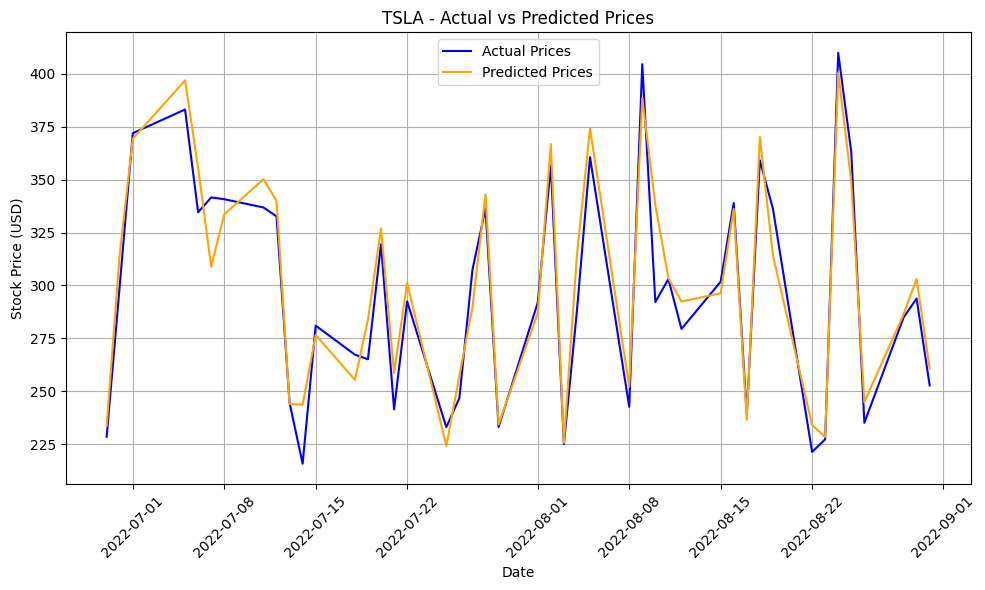

Generating plots for AAPL...


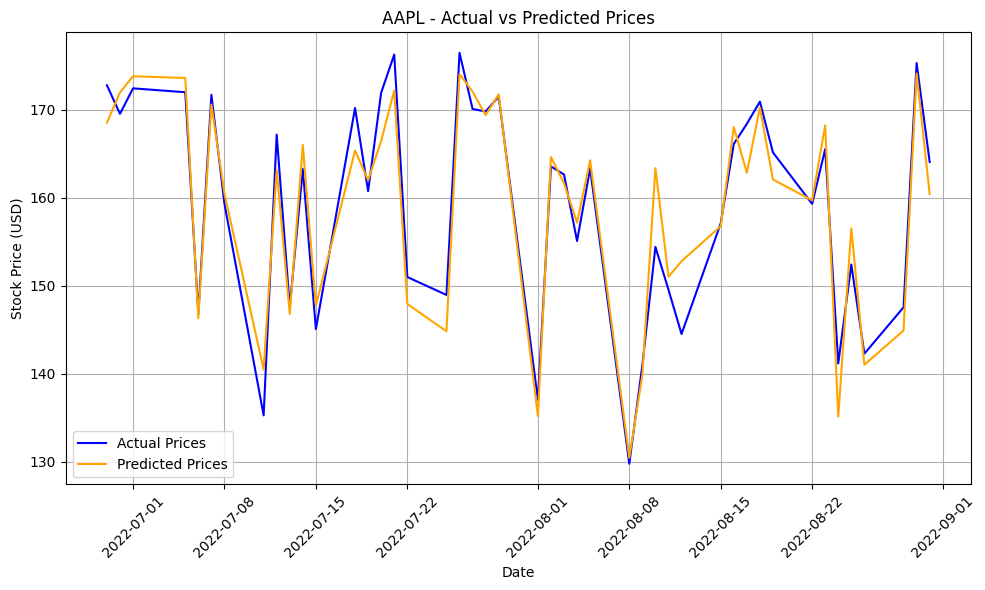

Generating plots for AMZN...


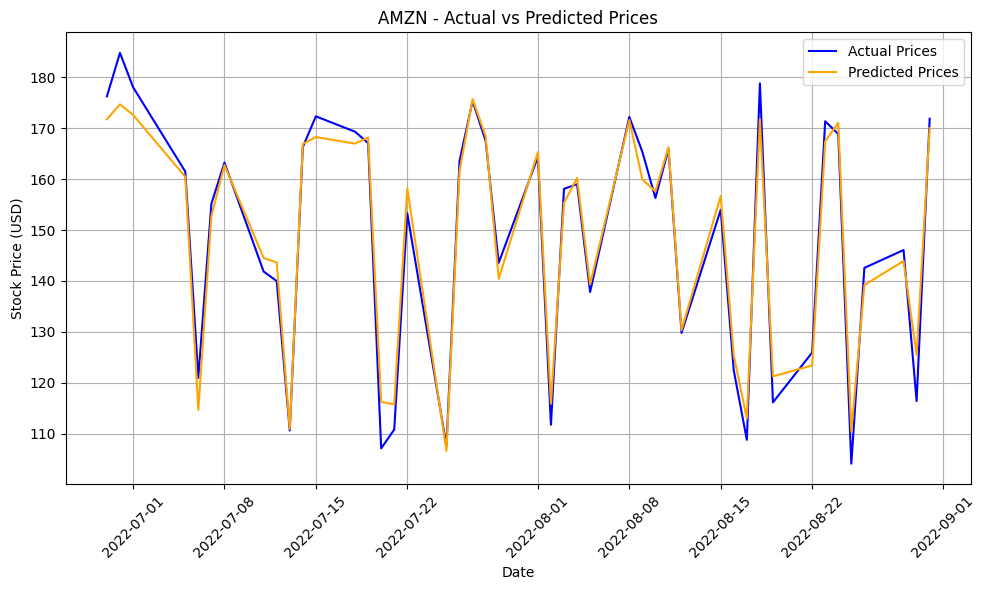

In [9]:
# Plot actual vs predicted prices for each stock with denormalization
for stock in stock_files.keys():
    print(f"Generating plots for {stock}...")
    
    # Retrieve data loaders and model
    test_loader = data_loaders[stock]['test_loader']
    model = models[stock]
    scaler = scalers[stock]  # Ensure the correct scaler for the stock is used

    # Evaluate the model on the test set
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch)
            predictions.extend(outputs.squeeze().cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())
    
    # Denormalize predictions and actuals
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    predictions_denormalized = scaler.inverse_transform(predictions)
    actuals_denormalized = scaler.inverse_transform(actuals)
    
    # Fetch corresponding dates
    dates = stock_data[stock]['Date'].iloc[-len(actuals):]  # Adjust the date column as per your dataset
    dates = pd.to_datetime(dates)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(dates, actuals_denormalized, label="Actual Prices", color='blue')
    plt.plot(dates, predictions_denormalized, label="Predicted Prices", color='orange')
    plt.title(f"{stock} - Actual vs Predicted Prices")
    plt.xlabel("Date")
    plt.ylabel("Stock Price (USD)")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [10]:
import torch
import os
# Directory to save the models
model_save_dir = r"C:\Users\AFFAN\github projects\StockPrediction\saved_models"
os.makedirs(model_save_dir, exist_ok=True)

# Save each model
for stock, model in models.items():
    model_path = os.path.join(model_save_dir, f"{stock}_model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for {stock} saved to {model_path}")


Model for TSLA saved to C:\Users\AFFAN\github projects\StockPrediction\saved_models\TSLA_model.pth
Model for AAPL saved to C:\Users\AFFAN\github projects\StockPrediction\saved_models\AAPL_model.pth
Model for AMZN saved to C:\Users\AFFAN\github projects\StockPrediction\saved_models\AMZN_model.pth
